error analysis

In [1]:
import sys
sys.path.append('../../')

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from modules import machine_learning_utils as mlu

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

# 1.0 Data retrieval

In [3]:
df = pd.read_pickle("../../data_lake/output/train_eng.pkl")
val = pd.read_pickle("../../data_lake/output/val_eng.pkl")

In [4]:
# df = df.drop(columns=['addr1', 'addr2','id_21', 'id_22', 'id_23', 'id_24', 'id_25',
#        'id_26', 'id_27', 'id_28', 'id_29','id_35', 'id_36', 'id_37', 'id_38','id_34','M4','id_32','R_emaildomain','id_30','id_33','num_transaction_per_time'])

In [5]:
df = df.drop(columns=['addr1', 'addr2','id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29','id_35', 'id_36', 'id_37', 'id_38','id_34','id_32','M4'])

In [6]:
val = val.drop(columns=['addr1', 'addr2','id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29','id_35', 'id_36', 'id_37', 'id_38','id_34','id_32','M4'])

# 2.0 Training baseline

In [7]:
for i in df:
    if df[i].dtypes == 'object':
        df[i] = df[i].astype(str)

In [8]:
X_train = df.drop(columns='isFraud')
y_train = df['isFraud'].astype(float)

In [9]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [10]:
# parameters = {'model__max_depth':[3,6,10],
#               'model__n_estimators':[100,400,800],
#               'model__learning_rate':[0.05,0.01,0.1],
#               'model__min_samples_leaf':[1,3],
#               'model__min_samples_split':[2,4,6]}

In [11]:
# {'model__learning_rate': 0.5, 'model__max_depth': 6, 'model__min_samples_leaf': 3, 'model__n_estimators': 600}

In [12]:
parameters = {'model__max_depth':[6,10],'model__n_estimators':[500,1000],'model__learning_rate':[0.05,0.1],'model__min_samples_leaf':[3,5]}

In [13]:
model = mlu.model_training(X_train,y_train,numerical_cols,categorical_cols,parameters)

GridSearchCV results...
Mean Train Scores: 
[0.89439805 0.90868301 0.89327687 0.90914007 0.94979422 0.95074929
 0.94991914 0.95158027 0.9140403  0.91840076 0.91416441 0.91507796
 0.9571859  0.9571859  0.95448699 0.95448699]

Mean CV Scores: 
[0.84589493 0.84950766 0.84502323 0.85125149 0.85536359 0.85611116
 0.85586129 0.85623498 0.852498   0.85411733 0.85013072 0.84988153
 0.85822869 0.85822869 0.85523766 0.85523766]

Best Parameters: 
{'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__n_estimators': 500}



# 3.0 Evaluation baseline

In [14]:
for i in val:
    if val[i].dtypes == 'object':
        val[i] = val[i].astype(str)

In [15]:
X_val = val.drop(columns='isFraud')
y_val = val['isFraud'].astype(float)

In [16]:
m = mlu.model_calibration(model,X_val,y_val)

Test results...
Model Test Recall: 0.8571428571428571
--------------------------------------------------
Model Test Confusion Matrix
Classification report : 
               precision    recall  f1-score   support

         0.0       0.99      0.87      0.92     19976
         1.0       0.35      0.86      0.50      1659

    accuracy                           0.87     21635
   macro avg       0.67      0.86      0.71     21635
weighted avg       0.94      0.87      0.89     21635

ProductCD: 0.29052631244685445
TransactionAmt: 0.10884804570053483
card1: 0.10323171248206102
card6: 0.02204498388156336
card5: 0.009367015481096941
P_emaildomain: 0.0046313088583090365
R_emaildomain: 0.0031996991828832405
card2: 0.000453789164894545
card3: 0.00029370048306628027
max_d: 6.152959573825484e-05
card4: 5.59230283231895e-05
browser_enc: 2.0931779344865556e-05
max_c: 1.7068560771231656e-05
num_transaction_per_time: 0.0
multi_transaction_per_time: 0.0
id_33: 0.0
id_30: 0.0
device_info_v4: 0.0
Device

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(add_indicator=True,
                                                                                    estimator=ExtraTreesRegressor(n_estimators=5,
                                                                                                                  random_state=1),
                                                                                    random_state=1)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['TransactionAmt', 'max_c', 'max_d', 'num_transaction_per_time',
       'multi_transaction_per_t...
                           

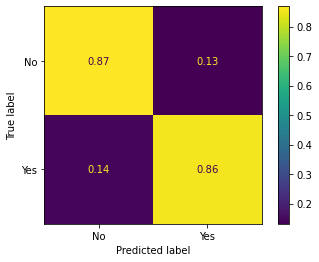

In [17]:
mlu.model_evaluation(m.base_estimator, X_val, y_val)

# 4.0 Error analysis

In [18]:
val.insert(0,'probability_score','')
val['probability_score'] = model.predict_proba(X_val)[:,1]

In [19]:
val.sample(2)

,probability_score,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,P_emaildomain,R_emaildomain,id_30,id_33,DeviceType,max_c,max_d,num_transaction_per_time,multi_transaction_per_time,browser_enc,device_info_v4
55958,0.069647,0,27.136,C,13832,375.0,185.0,mastercard,224.0,debit,hotmail.com,hotmail.com,nan,nan,desktop,1.0,0.0,1,0,chrome,windows
22195,0.007953,0,25.000,R,16227,543.0,150.0,mastercard,224.0,debit,anonymous.com,anonymous.com,iOS_11_1_2,2048x1536,mobile,1.0,0.0,1,0,safari,ios


In [28]:
er = val[(val['probability_score']<0.05) & (val['isFraud']=='1')]

In [29]:
er.shape

(28, 21)

In [30]:
er.sample(5)

,probability_score,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,P_emaildomain,R_emaildomain,id_30,id_33,DeviceType,max_c,max_d,num_transaction_per_time,multi_transaction_per_time,browser_enc,device_info_v4
83518,0.034218,1,50.000,R,12808,555.0,150.0,visa,226.0,debit,gmail.com,gmail.com,iOS_11_2_2,1334x750,mobile,1.0,0.000,1,0,safari,ios
121697,0.045263,1,47.708,C,15257,375.0,185.0,mastercard,224.0,debit,hotmail.com,hotmail.com,nan,nan,desktop,1.0,547.000,1,0,chrome,other
39930,0.034092,1,40.000,H,6019,583.0,150.0,visa,226.0,credit,gmail.com,gmail.com,Android_5_1_1,960x540,mobile,1.0,0.000,1,0,chrome,samsung
57522,0.015318,1,100.000,R,8528,215.0,150.0,visa,226.0,debit,gmail.com,aol.com,Mac_OS_X_10_13_1,2880x1800,desktop,1.0,0.000,1,0,safari,ios
10135,0.031790,1,50.000,S,12883,404.0,150.0,visa,226.0,credit,nan,gmail.com,Windows_10,1366x768,desktop,1.0,229.875,1,0,chrome,windows


<AxesSubplot:>

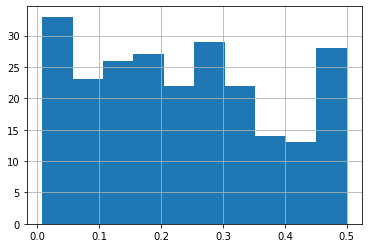

In [23]:
er['probability_score'].hist()

In [24]:
for i in er:
    print(i)
    print(er[i].value_counts(normalize=True).head(5))

probability_score
0.435288    0.008439
0.485538    0.008439
0.235251    0.008439
0.035126    0.004219
0.398104    0.004219
Name: probability_score, dtype: float64
isFraud
1    1.0
Name: isFraud, dtype: float64
TransactionAmt
100.0    0.075949
150.0    0.059072
50.0     0.046414
200.0    0.021097
175.0    0.021097
Name: TransactionAmt, dtype: float64
ProductCD
C    0.658228
R    0.156118
H    0.139241
S    0.046414
Name: ProductCD, dtype: float64
card1
15885    0.147679
5812     0.054852
3154     0.046414
4461     0.029536
13832    0.025316
Name: card1, dtype: float64
card2
545.0    0.206751
408.0    0.105485
555.0    0.075949
375.0    0.067511
514.0    0.037975
Name: card2, dtype: float64
card3
185.0    0.573840
150.0    0.367089
119.0    0.016878
106.0    0.008439
147.0    0.008439
Name: card3, dtype: float64
card4
visa                0.594937
mastercard          0.362869
discover            0.021097
american express    0.021097
Name: card4, dtype: float64
card5
226.0    0.278481
224.

# 4.0 Model Output

In [15]:
with open('../../data_lake/output/trained_model_v1.pkl','wb') as file:
    pickle.dump(m.base_estimator, file)